In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 15.6 MB/s eta 0:00:00


In [28]:
import pandas as pd
import numpy as np
import torch
import xgboost as xgb ## python Xgbost
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, label_binarize, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix ,precision_recall_curve,precision_recall_fscore_support
from sklearn.model_selection  import train_test_split, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline


In [3]:
train_word = pd.read_csv('/content/drive/MyDrive/challenge_log_data/only_word_train')
test_word = pd.read_csv('/content/drive/MyDrive/challenge_log_data/only_word_test')
# PyTorch 텐서 로드
embeddings = torch.load('/content/drive/MyDrive/challenge_log_data/train_ids.pt')
EDA_Oversampling = pd.read_csv('/content/drive/MyDrive/challenge_log_data/EDA_Dup_Oversampling (1).csv')
Auto_LOF5 = pd.read_csv('/content/drive/MyDrive/challenge_log_data/lof_results_k5.csv')
Auto_LOF3 = pd.read_csv('/content/drive/MyDrive/challenge_log_data/lof_results_k3.csv')
Auto_LOF7 = pd.read_csv('/content/drive/MyDrive/challenge_log_data/lof_results_k7.csv')
test_embeddings = torch.load('/content/drive/MyDrive/challenge_log_data/input_ids.pt')
submission_df = pd.read_csv('/content/drive/MyDrive/challenge_log_data/sample_submission.csv')
train_word = pd.read_csv('/content/drive/MyDrive/challenge_log_data/only_word_train')
test_word = pd.read_csv('//content/drive/MyDrive/challenge_log_data/only_word_test')

In [4]:
train_word['cut'] = train_word['cut'].fillna('')
test_word['cut'] = test_word['cut'].fillna('')
vectorizer=CountVectorizer(analyzer="word", max_features=20000)
X_features = vectorizer.fit_transform(train_word['cut'])
X_features_full = vectorizer.transform(test_word['cut'])
y_labels = train_word['level']

In [ ]:
y_labels.unique()

array([0, 1, 3, 5, 2, 4, 6])

In [12]:
## 20%을 test data에 사용
X_train, X_test, y_train , y_test = train_test_split(X_features, y_labels, test_size = 0.2, random_state = 156)

In [ ]:
X_train.shape,X_test.shape

((378377, 2000), (94595, 2000))

In [13]:
## numpy 형태를  DMatrix 형태로 변환
dtrain = xgb.DMatrix(data = X_train , label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [34]:
# XGBoost 분류기를 One-vs-Rest로 래핑
xgb_model = xgb.XGBClassifier(random_state=42)

In [32]:
class_weights = {2: 2, 4: 2, 6: 2}
sample_weights = y_train.map(class_weights).fillna(1).values

In [33]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 6],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [35]:
# f1_score - macro 스코어링 함수 설정
f1_macro_scorer = make_scorer(f1_score, average='macro')

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=f1_macro_scorer, cv=3, verbose=1, n_jobs=2)

# GridSearchCV 학습
grid_search.fit(X_train, y_train, sample_weight=sample_weights)

# 최적 파라미터 출력
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best F1 score (macro): {grid_search.best_score_}')

# 테스트 데이터에 대해 예측 수행
y_pred = grid_search.predict(X_test)
f1_macro_test = f1_score(y_test, y_pred, average='macro')
print(f'Test F1 score (macro): {f1_macro_test}')
##8분

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 1.0}
Best F1 score (macro): 0.9390120356646242
Test F1 score (macro): 0.9951170720538637


In [ ]:
print("Best hyperparamater", grid_search.best_params_)
print("Best F1-macro score ", grid_search.best_score_)

Best hyperparamater {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 1.0}
Best F1-macro score  0.9389211293816379


In [ ]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
predictions_prob = best_model.predict_proba(X_test)

In [ ]:
best_model.save_model('/content/drive/MyDrive/challenge_log_data/XGB_best_model.xgb')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:51:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [ ]:
# 성능 평가 ,데이터의 불균형 문제일 가능성도 있음
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     66950
           1       1.00      1.00      1.00     26357
           2       1.00      1.00      1.00         3
           3       1.00      0.99      1.00       809
           4       1.00      1.00      1.00         4
           5       1.00      0.95      0.97       470
           6       1.00      1.00      1.00         2

    accuracy                           1.00     94595
   macro avg       1.00      0.99      1.00     94595
weighted avg       1.00      1.00      1.00     94595

Confusion Matrix:
 [[66901    48     0     1     0     0     0]
 [  129 26227     0     0     0     1     0]
 [    0     0     3     0     0     0     0]
 [    6     0     0   803     0     0     0]
 [    0     0     0     0     4     0     0]
 [   22     0     0     0     0   448     0]
 [    0     0     0     0     0     0     2]]


In [ ]:
## F1- score를 최적화 하는 optimalthrehold
optimal_thresholds = {}
classes = np.unique(y_train)

Class 0 - Optimal Threshold: 0.21869702637195587, F1 Score: 0.9986500093231401
Class 1 - Optimal Threshold: 0.8174238801002502, F1 Score: 0.9971655220956114
Class 2 - Optimal Threshold: 0.9208288192749023, F1 Score: 1.0
Class 3 - Optimal Threshold: 0.6801162958145142, F1 Score: 0.9956602603843768
Class 4 - Optimal Threshold: 0.878081202507019, F1 Score: 1.0
Class 5 - Optimal Threshold: 0.6224785447120667, F1 Score: 0.9760348583877996
Class 6 - Optimal Threshold: 0.8354929089546204, F1 Score: 1.0


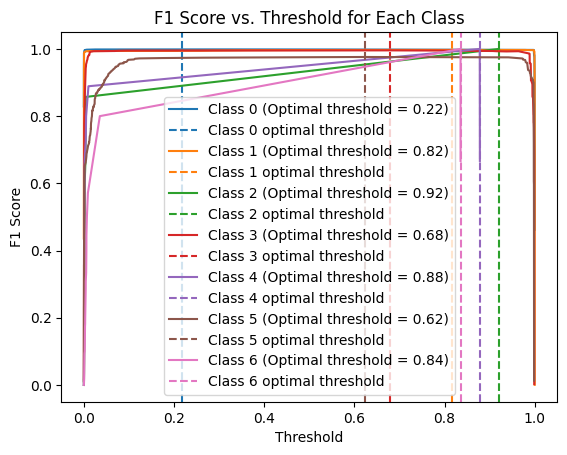

In [ ]:
for i, class_label in enumerate(classes):
  precision, recall, thresholds = precision_recall_curve(label_binarize(y_test, classes=classes)[:, i], predictions_prob[:, i])
  f1_scores = 2 * (precision * recall) / (precision + recall)
  optimal_idx = np.argmax(f1_scores)
  optimal_threshold = thresholds[optimal_idx]
  optimal_thresholds[class_label] = optimal_threshold
  print(f'Class {class_label} - Optimal Threshold: {optimal_threshold}, F1 Score: {f1_scores[optimal_idx]}')

  # Precision-Recall 곡선 시각화
  plt.plot(thresholds, f1_scores[:-1], label=f'Class {class_label} (Optimal threshold = {optimal_threshold:.2f})')
  plt.axvline(x=optimal_threshold, linestyle='--', label=f'Class {class_label} optimal threshold', color=plt.gca().lines[-1].get_color())

plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold for Each Class')
plt.legend(loc='best')
plt.show()



In [ ]:
prediction_full = best_model.predict(X_features_full)
prediction_full_prob = best_model.predict_proba(X_features_full)

In [ ]:
## level 6을 threhold 값으로 처리할 경우 data 모두 다 level 7로 분류 되는 문제
prediction_full[np.where((np.max(prediction_full_prob, axis = 1) < 0.22) & (prediction_full == 0))] = 7
prediction_full[np.where((np.max(prediction_full_prob, axis = 1) < 0.82) & (prediction_full == 1))] = 7
## prediction_full[np.where((np.max(prediction_full_prob, axis = 1) < 0.92) & (prediction_full == 2))] = 7
prediction_full[np.where((np.max(prediction_full_prob, axis = 1) < 0.68) & (prediction_full == 3))] = 7
## prediction_full[np.where((np.max(prediction_full_prob, axis = 1) < 0.88) & (prediction_full == 4))] = 7
prediction_full[np.where((np.max(prediction_full_prob, axis = 1) < 0.62) & (prediction_full == 5))] = 7
## prediction_full[np.where((np.max(prediction_full_prob, axis = 1) < 0.84) & (prediction_full == 6))] = 7

In [ ]:
Xg_submission_df = pd.DataFrame({
    'id': test_word['id'],
    'level': prediction_full
})

In [ ]:
Xg_submission_df['level'].value_counts()

level
0    1003508
1     395092
3      12889
5       6350
7       1043
2         34
Name: count, dtype: int64

In [ ]:
Xg_submission_df = Xg_submission_df.drop_duplicates()
Xg_submission_df['level'].value_counts()

level
0    1003508
1     395092
3      12889
5       6350
7       1043
2         34
Name: count, dtype: int64

In [ ]:
Xg_submission_df.to_csv('/content/drive/MyDrive/challenge_log_data/XgbostSubmission.csv', index = False)

In [ ]:
tmp = pd.read_csv('/content/drive/MyDrive/challenge_log_data/XgbostSubmission.csv')
tmp['level'].value_counts()

level
0    1003508
1     395092
3      12889
5       6350
7        988
2         34
4         34
6         21
Name: count, dtype: int64

## Autoencoer TF-IDF


In [ ]:
# Min-Max 정규화
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.toarray())
X_test_scaled = scaler.transform(X_test.toarray())
test_embeddings_scaled = scaler.transform(X_features_full.toarray())

In [ ]:
# numpy 형태를 DMatrix 형태로 변환
dtrain = xgb.DMatrix(data=X_train_scaled, label=y_train)
dtest = xgb.DMatrix(data=X_test_scaled, label=y_test)

In [ ]:
# 함수 정의: LOF 결과 기반으로 이상치 제거
def remove_anomalies(train_ids, labels, lof_results, column_name):
    lof_results[column_name] = lof_results[column_name].astype(bool)
    anomalous_indices = lof_results[lof_results[column_name]].index.tolist()
    train_ids_np = train_ids
    filtered_train_ids = np.delete(train_ids_np, anomalous_indices, axis=0)
    filtered_labels = np.delete(labels, anomalous_indices, axis=0)
    return filtered_train_ids, filtered_labels

## disti-bert XGBOOST


In [ ]:
!pip install pandas transformers torch xgboost scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# PyTorch 텐서 로드
embeddings = torch.load('/content/drive/MyDrive/challenge_log_data/train_ids.pt')

EDA_Oversampling = pd.read_csv('/content/drive/MyDrive/challenge_log_data/EDA_Dup_Oversampling (1).csv')

In [ ]:
embeddings = embeddings.numpy()

In [ ]:
EDA_Oversampling['level'].value_counts()

level
1    55090
0     3476
5      610
3      527
6       55
4       22
2       11
Name: count, dtype: int64

In [ ]:
# 4. Extract and preprocess labels
labels = EDA_Oversampling['level']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


In [ ]:
label_encoder.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(embeddings, labels_encoded, test_size=0.2, random_state=42)

In [ ]:
dtrain = xgb.DMatrix(data = X_train , label = y_train)
dvalid = xgb.DMatrix(data = X_valid, label = y_valid)

In [ ]:
# 클래스 가중치 설정 (예: 클래스 2, 4, 6에 대해 높은 가중치 부여)
class_weights = {0: 1, 1: 1, 2: 3, 3: 1, 4: 3, 5: 1, 6: 3}

# 각 샘플에 대한 가중치 부여
sample_weights = [class_weights[label] for label in y_train]

In [ ]:

# XGBoost 모델 설정
param_grid = {
    'learning_rate': [0.1, 0.2],  # 학습률 (과적합 제어)
    'max_depth': [4, 6],  # 트리의 최대 깊이 (모델 복잡성 제어)
    'min_child_weight': [1, 3],  # 자식 노드의 최소 가중치 (과소적합 방지)
    'subsample': [0.8, 1.0],  # 훈련 데이터의 샘플링 비율 (과적합 제어)
    'colsample_bytree': [0.8, 1.0],  # 각 트리에서 사용할 특성의 비율 (과적합 제어)
}


In [ ]:
# XGBoost 모델 학습
model = xgb.XGBClassifier(
    objective='multi:softprob',  # 다중 클래스 분류를 위한 소프트맥스 확률 출력
    num_class=len(label_encoder.classes_),  # 클래스 수
    importance_type='total_gain',  # 특성 중요도 계산 방법
    random_state=42
)

In [ ]:
model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='mlogloss',  # 다중 클래스 분류를 위한 평가 지표
    sample_weight=sample_weights,  # 클래스 가중치 적용
    early_stopping_rounds=10,  # 조기 종료 설정
    verbose=True,
)
model.score(X_valid, y_valid)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.03010
[1]	validation_0-mlogloss:0.70180
[2]	validation_0-mlogloss:0.50082
[3]	validation_0-mlogloss:0.36563
[4]	validation_0-mlogloss:0.27127
[5]	validation_0-mlogloss:0.20390
[6]	validation_0-mlogloss:0.15534
[7]	validation_0-mlogloss:0.11988
[8]	validation_0-mlogloss:0.09366
[9]	validation_0-mlogloss:0.07447
[10]	validation_0-mlogloss:0.06034
[11]	validation_0-mlogloss:0.04994
[12]	validation_0-mlogloss:0.04222
[13]	validation_0-mlogloss:0.03647
[14]	validation_0-mlogloss:0.03216
[15]	validation_0-mlogloss:0.02900
[16]	validation_0-mlogloss:0.02662
[17]	validation_0-mlogloss:0.02481
[18]	validation_0-mlogloss:0.02349
[19]	validation_0-mlogloss:0.02245
[20]	validation_0-mlogloss:0.02176
[21]	validation_0-mlogloss:0.02119
[22]	validation_0-mlogloss:0.02075
[23]	validation_0-mlogloss:0.02048
[24]	validation_0-mlogloss:0.02028
[25]	validation_0-mlogloss:0.02032
[26]	validation_0-mlogloss:0.02026
[27]	validation_0-mlogloss:0.02021
[28]	validation_0-mlogloss:0.0

0.9923906681160632

In [ ]:
model.save_model('/content/drive/MyDrive/challenge_log_data/BertXgModel.xgb')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:45:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [ ]:
new_xgb_model = xgb.XGBClassifier() # 모델 초기화
new_xgb_model.load_model('/content/drive/MyDrive/challenge_log_data/BertXgModel.xgb') # 모델 불러오기

In [ ]:
test_embeddings = torch.load('/content/drive/MyDrive/challenge_log_data/input_ids.pt')

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/challenge_log_data/sample_submission.csv')

In [ ]:
results = model.predict(test_embeddings)
results_proba = model.predict_proba(test_embeddings)

In [ ]:
k = 5

# 각 클래스별로 kNN을 사용하여 임계값 계산
optimal_thresholds = []
for i in range(results_proba.shape[1]):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(results_proba[:, i].reshape(-1, 1))
    distances, indices = nbrs.kneighbors(results_proba[:, i].reshape(-1, 1))

    # 이웃들의 확률 값을 사용하여 임계값 계산
    neighbors_proba = results_proba[indices.flatten(), i]
    optimal_threshold = np.mean(neighbors_proba)  # 이웃들의 평균 확률 값을 임계값으로 사용
    optimal_thresholds.append(optimal_threshold)
    print(f"Optimal threshold for class {i}: {optimal_threshold}")

print("Optimal thresholds:", optimal_thresholds)

Optimal threshold for class 0: 0.6894245743751526
Optimal threshold for class 1: 0.2863880693912506
Optimal threshold for class 2: 0.0005005670245736837
Optimal threshold for class 3: 0.013150977902114391
Optimal threshold for class 4: 0.0006168092950247228
Optimal threshold for class 5: 0.007014433853328228
Optimal threshold for class 6: 0.0029042637906968594
Optimal thresholds: [0.6894246, 0.28638807, 0.000500567, 0.013150978, 0.0006168093, 0.007014434, 0.0029042638]


In [ ]:
results[np.where((np.max(results_proba, axis = 1) < 0.6894245743751526) & (results == 0))] = 7
results[np.where((np.max(results_proba, axis = 1) < 0.2863880693912506) & (results == 1))] = 7
results[np.where((np.max(results_proba, axis = 1) < 0.0005005670245736837) & (results == 2))] = 7
results[np.where((np.max(results_proba, axis = 1) < 0.013150977902114391) & (results == 3))] = 7
results[np.where((np.max(results_proba, axis = 1) < 0.0006168092950247228) & (results == 4))] = 7
results[np.where((np.max(results_proba, axis = 1) < 0.007014433853328228) & (results == 5))] = 7
results[np.where((np.max(results_proba, axis = 1) < 0.0029042637906968594) & (results == 6))] = 7

In [ ]:
pd.Series(results).value_counts()

0    1000617
1     396926
3      12926
5       6436
7       1896
4         48
2         34
6         33
Name: count, dtype: int64

In [ ]:
submission_df = pd.DataFrame({
    'id': submission['id'],
    'level': results
})

In [ ]:
submission_df.to_csv('/content/drive/MyDrive/challenge_log_data/BertXgbostSubmission.csv',index=False)

## AutoencoderLOF level 7 XGbost

In [8]:
labels = EDA_Oversampling['level']

In [10]:
# 함수 정의: LOF 결과 기반으로 이상치 제거
def remove_anomalies(train_ids, labels, lof_results, column_name):
    lof_results[column_name] = lof_results[column_name].astype(bool)
    anomalous_indices = lof_results[lof_results[column_name]].index.tolist()
    train_ids_np = train_ids.numpy()
    filtered_train_ids = np.delete(train_ids_np, anomalous_indices, axis=0)
    filtered_labels = np.delete(labels, anomalous_indices, axis=0)
    return torch.tensor(filtered_train_ids), filtered_labels

In [11]:
# XGBoost 모델 학습 함수 정의
def train_xgboost(train_ids, labels, weighted_classes=[]):
    X_train, X_val, y_train, y_val = train_test_split(train_ids.numpy(), labels, test_size=0.2, random_state=42)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 클래스 가중치 설정
    classes, counts = np.unique(y_train, return_counts=True)
    class_weights = {cls: 1.0 for cls in classes}
    for cls in weighted_classes:
        if cls in classes:
            class_weights[cls] = max(counts) / counts[classes == cls][0]

    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(labels)),
        'eval_metric': 'mlogloss',
        'max_depth': 6,
        'eta': 0.3,
        'scale_pos_weight': sum(class_weights[cls] for cls in weighted_classes) / len(weighted_classes) if weighted_classes else 1.0
    }

    evals = [(dtrain, 'train'), (dval, 'val')]
    eval_results = {}
    bst = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10, evals_result=eval_results)

    y_pred = bst.predict(dval)
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f'Validation F1-score (macro): {f1:.4f}')

    # classification_report 출력 및 반환
    report = classification_report(y_val, y_pred, target_names=[f'Class {i}' for i in np.unique(labels)], output_dict=True)
    print(report)

    return bst, eval_results, y_val, y_pred, report

In [12]:
# 시각화 함수 정의
def plot_metrics(eval_results, report):
    epochs = len(eval_results['train']['mlogloss'])
    x_axis = range(0, epochs)

    # Loss 그래프
    plt.figure(figsize=(12, 5))
    plt.plot(x_axis, eval_results['train']['mlogloss'], label='Train')
    plt.plot(x_axis, eval_results['val']['mlogloss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision, Recall, F1-score 시각화
    precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average=None)
    classes = [f'Class {i}' for i in range(len(precision))]

    plt.figure(figsize=(12, 5))
    bar_width = 0.2
    index = np.arange(len(classes))

    plt.bar(index, precision, bar_width, label='Precision')
    plt.bar(index + bar_width, recall, bar_width, label='Recall')
    plt.bar(index + 2 * bar_width, f1, bar_width, label='F1-score')

    plt.xlabel('Classes')
    plt.ylabel('Scores')
    plt.title('Precision, Recall, F1-score by Class')
    plt.xticks(index + bar_width, classes)
    plt.legend()
    plt.grid(True)
    plt.show()

Filtered train ids shape after removing is_level_7_k5: torch.Size([59049, 200])


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.02894	val-mlogloss:1.03067
[1]	train-mlogloss:0.69993	val-mlogloss:0.70271
[2]	train-mlogloss:0.49802	val-mlogloss:0.50169
[3]	train-mlogloss:0.36238	val-mlogloss:0.36663
[4]	train-mlogloss:0.26728	val-mlogloss:0.27209
[5]	train-mlogloss:0.19945	val-mlogloss:0.20457
[6]	train-mlogloss:0.15025	val-mlogloss:0.15577
[7]	train-mlogloss:0.11429	val-mlogloss:0.12014
[8]	train-mlogloss:0.08788	val-mlogloss:0.09395
[9]	train-mlogloss:0.06839	val-mlogloss:0.07468
[10]	train-mlogloss:0.05398	val-mlogloss:0.06047
[11]	train-mlogloss:0.04330	val-mlogloss:0.04992
[12]	train-mlogloss:0.03529	val-mlogloss:0.04216
[13]	train-mlogloss:0.02930	val-mlogloss:0.03638
[14]	train-mlogloss:0.02474	val-mlogloss:0.03203
[15]	train-mlogloss:0.02136	val-mlogloss:0.02880
[16]	train-mlogloss:0.01885	val-mlogloss:0.02639
[17]	train-mlogloss:0.01692	val-mlogloss:0.02457
[18]	train-mlogloss:0.01528	val-mlogloss:0.02329
[19]	train-mlogloss:0.01411	val-mlogloss:0.02231
[20]	train-mlogloss:0.01314	va

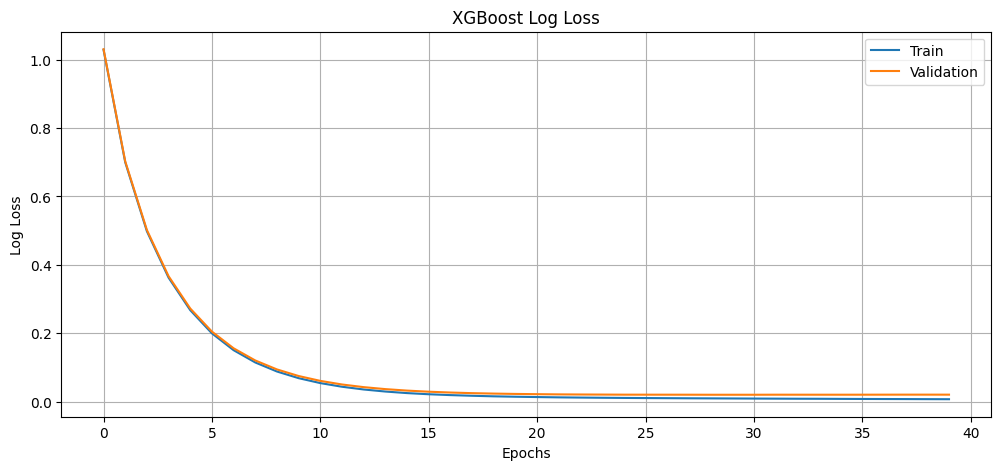

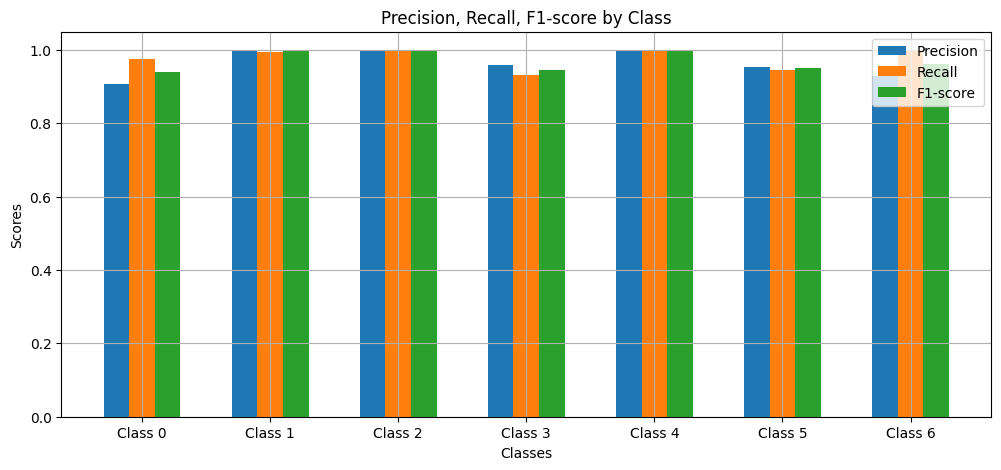

Filtered train ids shape after removing is_level_7_k3: torch.Size([59051, 200])


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.02877	val-mlogloss:1.02985
[1]	train-mlogloss:0.69978	val-mlogloss:0.70187
[2]	train-mlogloss:0.49813	val-mlogloss:0.50062
[3]	train-mlogloss:0.36263	val-mlogloss:0.36545
[4]	train-mlogloss:0.26772	val-mlogloss:0.27080
[5]	train-mlogloss:0.19992	val-mlogloss:0.20344
[6]	train-mlogloss:0.15074	val-mlogloss:0.15461
[7]	train-mlogloss:0.11471	val-mlogloss:0.11900
[8]	train-mlogloss:0.08822	val-mlogloss:0.09273
[9]	train-mlogloss:0.06866	val-mlogloss:0.07343
[10]	train-mlogloss:0.05427	val-mlogloss:0.05923
[11]	train-mlogloss:0.04361	val-mlogloss:0.04874
[12]	train-mlogloss:0.03566	val-mlogloss:0.04098
[13]	train-mlogloss:0.02969	val-mlogloss:0.03513
[14]	train-mlogloss:0.02524	val-mlogloss:0.03075
[15]	train-mlogloss:0.02178	val-mlogloss:0.02766
[16]	train-mlogloss:0.01920	val-mlogloss:0.02530
[17]	train-mlogloss:0.01709	val-mlogloss:0.02352
[18]	train-mlogloss:0.01546	val-mlogloss:0.02225
[19]	train-mlogloss:0.01425	val-mlogloss:0.02129
[20]	train-mlogloss:0.01325	va

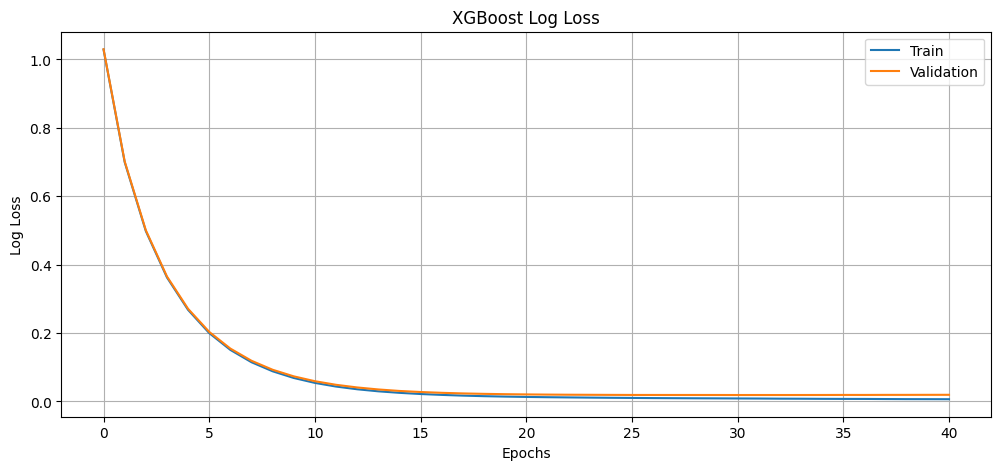

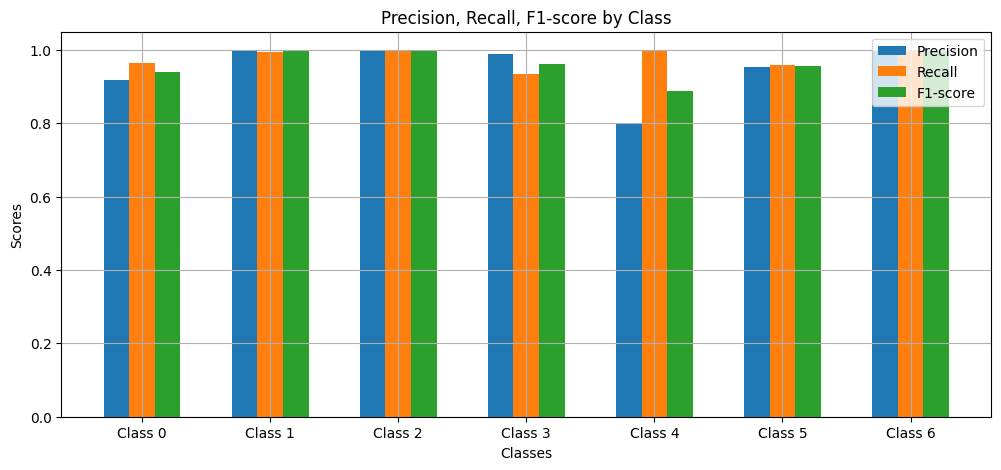

Filtered train ids shape after removing is_level_7_k7: torch.Size([59049, 200])


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:19:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.02885	val-mlogloss:1.02961
[1]	train-mlogloss:0.69983	val-mlogloss:0.70173
[2]	train-mlogloss:0.49810	val-mlogloss:0.50062
[3]	train-mlogloss:0.36244	val-mlogloss:0.36551
[4]	train-mlogloss:0.26747	val-mlogloss:0.27095
[5]	train-mlogloss:0.19958	val-mlogloss:0.20351
[6]	train-mlogloss:0.15032	val-mlogloss:0.15465
[7]	train-mlogloss:0.11443	val-mlogloss:0.11903
[8]	train-mlogloss:0.08796	val-mlogloss:0.09295
[9]	train-mlogloss:0.06835	val-mlogloss:0.07380
[10]	train-mlogloss:0.05393	val-mlogloss:0.05963
[11]	train-mlogloss:0.04315	val-mlogloss:0.04916
[12]	train-mlogloss:0.03514	val-mlogloss:0.04135
[13]	train-mlogloss:0.02921	val-mlogloss:0.03553
[14]	train-mlogloss:0.02468	val-mlogloss:0.03123
[15]	train-mlogloss:0.02124	val-mlogloss:0.02804
[16]	train-mlogloss:0.01866	val-mlogloss:0.02570
[17]	train-mlogloss:0.01672	val-mlogloss:0.02390
[18]	train-mlogloss:0.01516	val-mlogloss:0.02255
[19]	train-mlogloss:0.01386	val-mlogloss:0.02161
[20]	train-mlogloss:0.01292	va

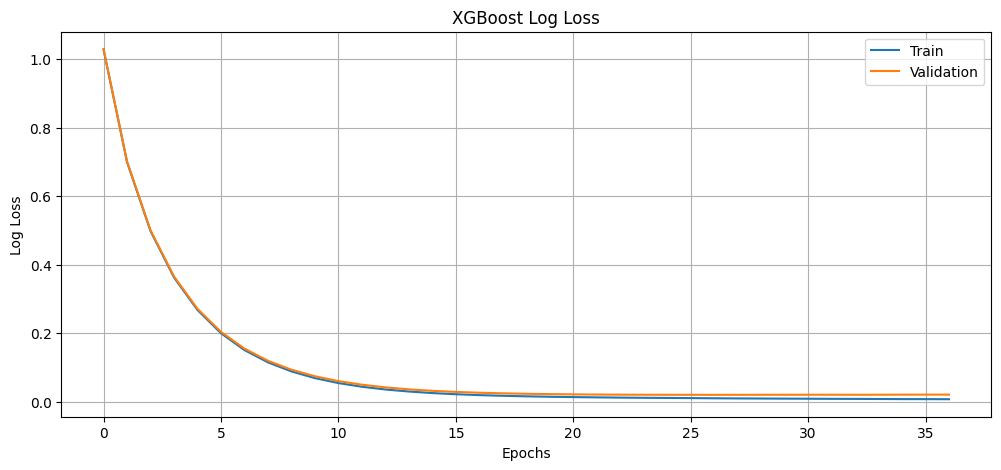

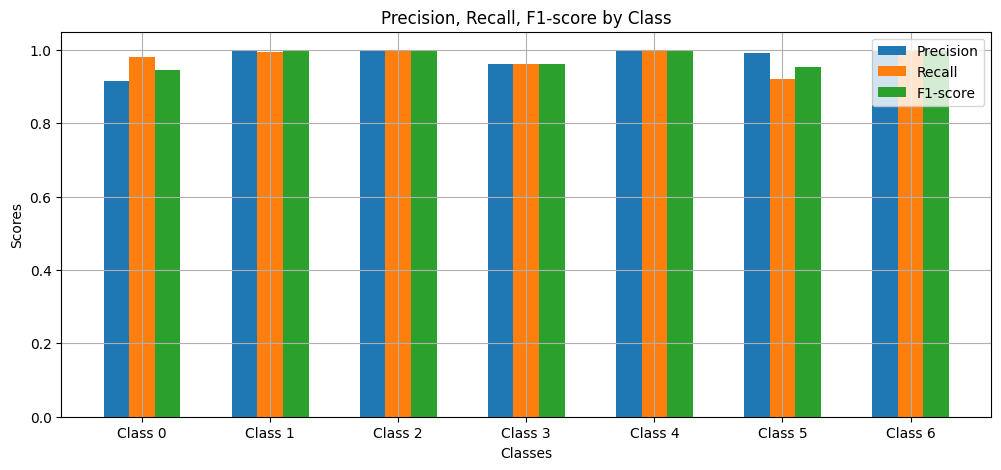

In [ ]:
# 순차적으로 LOF 결과 기반 이상치 제거 및 모델 학습
lof_results_list = [Auto_LOF5, Auto_LOF3, Auto_LOF7]
column_names = ['is_level_7_k5', 'is_level_7_k3', 'is_level_7_k7']
for i, (lof_results, column_name) in enumerate(zip(lof_results_list, column_names)):
    filtered_train_ids = embeddings
    filtered_labels = labels
    filtered_train_ids, filtered_labels = remove_anomalies(filtered_train_ids, filtered_labels, lof_results, column_name)
    print(f'Filtered train ids shape after removing {column_name}: {filtered_train_ids.shape}')

    # 모델 학습
    bst, eval_results, y_val, y_pred, report = train_xgboost(filtered_train_ids, filtered_labels, weighted_classes=[2, 4, 6])  # 클래스 2, 4, 6에 가중치를 부여

    # 테스트 데이터 예측
    dtest = xgb.DMatrix(test_embeddings.numpy())
    test_pred = bst.predict(dtest)

    # 예측 결과 추가
    final_predictions = test_pred.copy()

    lof_results[column_name] = lof_results[column_name].astype(bool)
    level_7_indices = lof_results[lof_results[column_name]].index.values
    # level 7 예측 결과 추가
    final_predictions[level_7_indices] = 7

    # 예측 결과를 정수로 변환하여 CSV로 저장
    submission_df['level'] = final_predictions.astype(int)
    submission_df.to_csv(f'final_submission_k{[5, 3, 7][i]}.csv', index=False)
    print(f'Saved predictions for K={[5, 3, 7][i]} as final_submission_k{[5, 3, 7][i]}.csv')

    # 학습 그래프 및 성능 시각화
    plot_metrics(eval_results, report)

In [ ]:
final = pd.read_csv('/content/final_submission_k7.csv')
final['level'].value_counts()

level
0    1002769
1     396078
3      12886
5       6342
7        742
2         34
4         34
6         31
Name: count, dtype: int64

In [23]:
# XGBoost 모델 학습 함수 정의 level 0~ 7
def train_xgboost_7(train_ids, labels, weighted_classes=[]):
    X_train, X_val, y_train, y_val = train_test_split(train_ids.numpy(), labels, test_size=0.2, random_state=42)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # 클래스 가중치 설정
    classes, counts = np.unique(y_train, return_counts=True)
    class_weights = {cls: 1.0 for cls in classes}
    for cls in weighted_classes:
        if cls in classes:
            class_weights[cls] = max(counts) / counts[classes == cls][0]

    params = {
        'objective': 'multi:softmax',
        'num_class': 8,  # 0부터 7까지 8개의 클래스
        'eval_metric': 'mlogloss',
        'max_depth': 6,
        'eta': 0.3,
        'scale_pos_weight': sum(class_weights[cls] for cls in weighted_classes) / len(weighted_classes) if weighted_classes else 1.0
    }

    evals = [(dtrain, 'train'), (dval, 'val')]
    eval_results = {}
    bst = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10, evals_result=eval_results)

    y_pred = bst.predict(dval)
    f1 = f1_score(y_val, y_pred, average='macro')
    print(f'Validation F1-score (macro): {f1:.4f}')

    # classification_report 출력 및 반환
    report = classification_report(y_val, y_pred, target_names=[f'Class {i}' for i in range(8)], output_dict=True)
    print(report)

    return bst, eval_results, y_val, y_pred, report

In [26]:
# 함수 정의: LOF 결과 기반으로 이상치 제거
def remove_anomalies_7(train_ids, labels, lof_results, column_name):
    lof_results[column_name] = lof_results[column_name].astype(bool)
    anomalous_indices = lof_results[lof_results[column_name]].index.tolist()
    train_ids_np = train_ids.numpy()
    filtered_train_ids = np.delete(train_ids_np, anomalous_indices, axis=0)
    filtered_labels = np.delete(labels, anomalous_indices, axis=0)
    return torch.tensor(filtered_train_ids), filtered_labels

Filtered train ids shape after removing is_level_7_k5: torch.Size([59049, 200])


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:36:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.06425	val-mlogloss:1.06623
[1]	train-mlogloss:0.74096	val-mlogloss:0.74394
[2]	train-mlogloss:0.54340	val-mlogloss:0.54720
[3]	train-mlogloss:0.41102	val-mlogloss:0.41559
[4]	train-mlogloss:0.31889	val-mlogloss:0.32424
[5]	train-mlogloss:0.25324	val-mlogloss:0.25961
[6]	train-mlogloss:0.20631	val-mlogloss:0.21327
[7]	train-mlogloss:0.17218	val-mlogloss:0.17997
[8]	train-mlogloss:0.14728	val-mlogloss:0.15581
[9]	train-mlogloss:0.12929	val-mlogloss:0.13841
[10]	train-mlogloss:0.11611	val-mlogloss:0.12580
[11]	train-mlogloss:0.10627	val-mlogloss:0.11656
[12]	train-mlogloss:0.09875	val-mlogloss:0.10986
[13]	train-mlogloss:0.09305	val-mlogloss:0.10485
[14]	train-mlogloss:0.08846	val-mlogloss:0.10119
[15]	train-mlogloss:0.08476	val-mlogloss:0.09845
[16]	train-mlogloss:0.08203	val-mlogloss:0.09639
[17]	train-mlogloss:0.07902	val-mlogloss:0.09499
[18]	train-mlogloss:0.07684	val-mlogloss:0.09374
[19]	train-mlogloss:0.07494	val-mlogloss:0.09268
[20]	train-mlogloss:0.07337	va

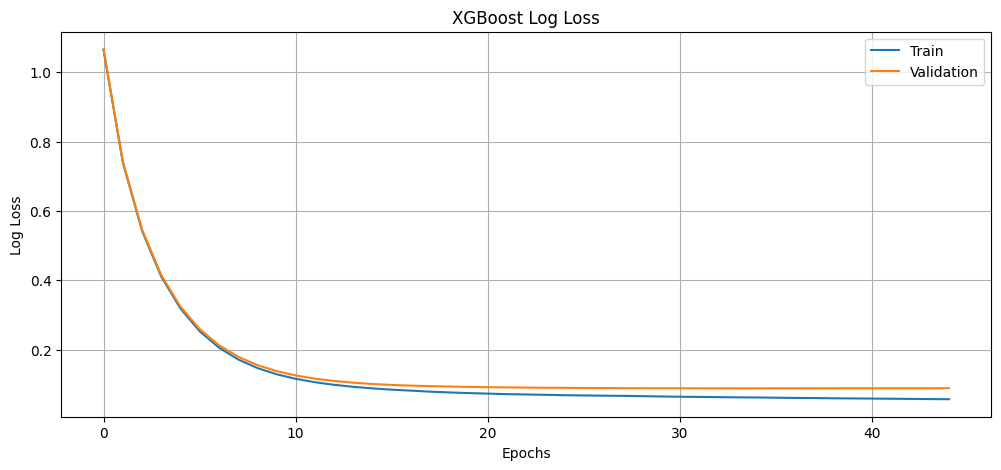

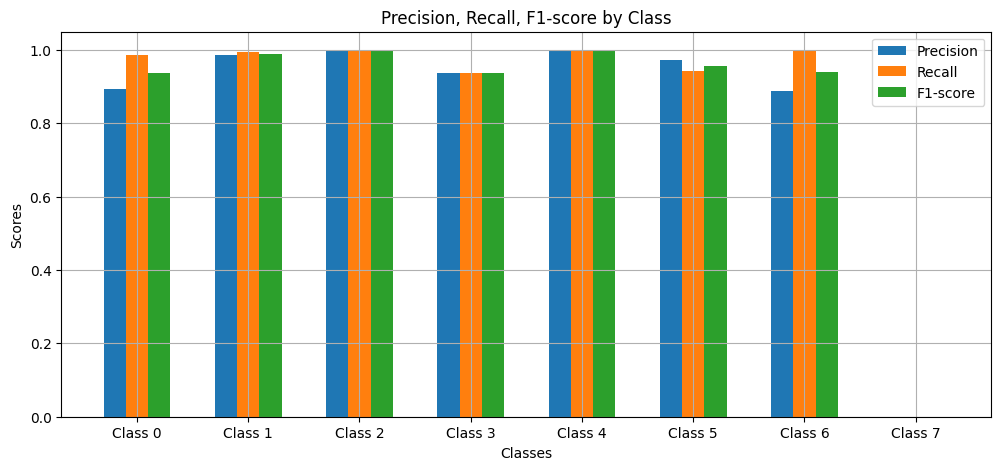

Filtered train ids shape after removing is_level_7_k3: torch.Size([59051, 200])


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:37:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.06393	val-mlogloss:1.06497
[1]	train-mlogloss:0.74067	val-mlogloss:0.74258
[2]	train-mlogloss:0.54325	val-mlogloss:0.54617
[3]	train-mlogloss:0.41105	val-mlogloss:0.41483
[4]	train-mlogloss:0.31884	val-mlogloss:0.32344
[5]	train-mlogloss:0.25347	val-mlogloss:0.25873
[6]	train-mlogloss:0.20657	val-mlogloss:0.21239
[7]	train-mlogloss:0.17267	val-mlogloss:0.17932
[8]	train-mlogloss:0.14793	val-mlogloss:0.15548
[9]	train-mlogloss:0.12993	val-mlogloss:0.13819
[10]	train-mlogloss:0.11659	val-mlogloss:0.12571
[11]	train-mlogloss:0.10660	val-mlogloss:0.11669
[12]	train-mlogloss:0.09903	val-mlogloss:0.11000
[13]	train-mlogloss:0.09299	val-mlogloss:0.10512
[14]	train-mlogloss:0.08820	val-mlogloss:0.10162
[15]	train-mlogloss:0.08443	val-mlogloss:0.09897
[16]	train-mlogloss:0.08164	val-mlogloss:0.09694
[17]	train-mlogloss:0.07879	val-mlogloss:0.09540
[18]	train-mlogloss:0.07663	val-mlogloss:0.09405
[19]	train-mlogloss:0.07489	val-mlogloss:0.09315
[20]	train-mlogloss:0.07338	va

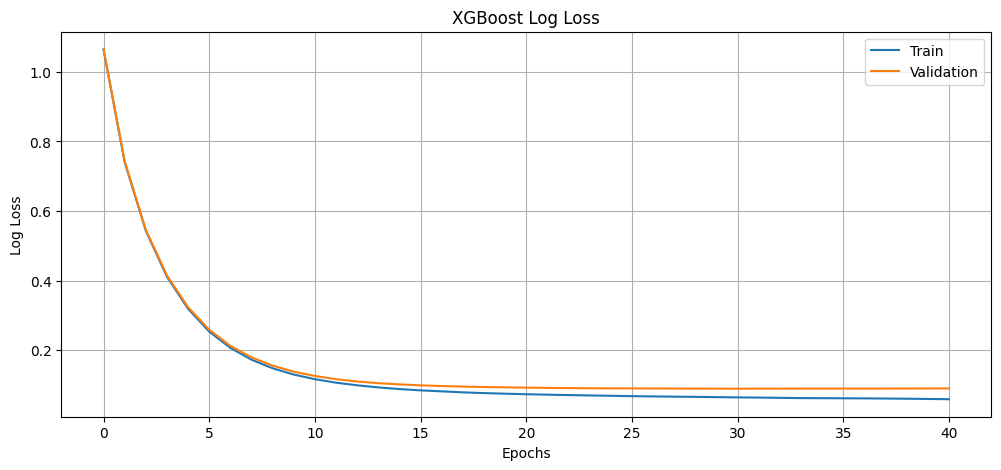

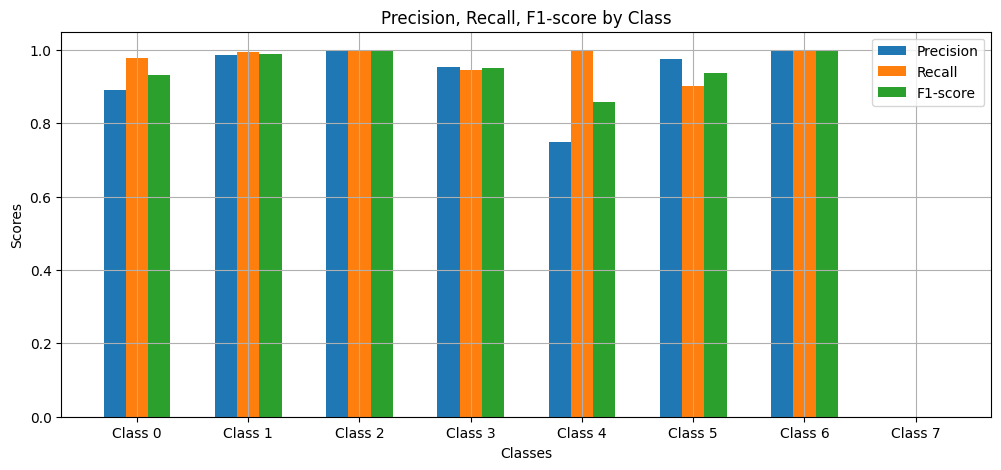

Filtered train ids shape after removing is_level_7_k7: torch.Size([59049, 200])


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:37:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.06394	val-mlogloss:1.06574
[1]	train-mlogloss:0.74092	val-mlogloss:0.74356
[2]	train-mlogloss:0.54347	val-mlogloss:0.54700
[3]	train-mlogloss:0.41100	val-mlogloss:0.41566
[4]	train-mlogloss:0.31893	val-mlogloss:0.32438
[5]	train-mlogloss:0.25340	val-mlogloss:0.25971
[6]	train-mlogloss:0.20642	val-mlogloss:0.21356
[7]	train-mlogloss:0.17216	val-mlogloss:0.18035
[8]	train-mlogloss:0.14706	val-mlogloss:0.15648
[9]	train-mlogloss:0.12903	val-mlogloss:0.13909
[10]	train-mlogloss:0.11563	val-mlogloss:0.12662
[11]	train-mlogloss:0.10581	val-mlogloss:0.11750
[12]	train-mlogloss:0.09837	val-mlogloss:0.11083
[13]	train-mlogloss:0.09269	val-mlogloss:0.10572
[14]	train-mlogloss:0.08834	val-mlogloss:0.10197
[15]	train-mlogloss:0.08475	val-mlogloss:0.09920
[16]	train-mlogloss:0.08193	val-mlogloss:0.09693
[17]	train-mlogloss:0.07929	val-mlogloss:0.09527
[18]	train-mlogloss:0.07697	val-mlogloss:0.09408
[19]	train-mlogloss:0.07521	val-mlogloss:0.09302
[20]	train-mlogloss:0.07319	va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saved predictions for K=7 as final_submission_k7.csv


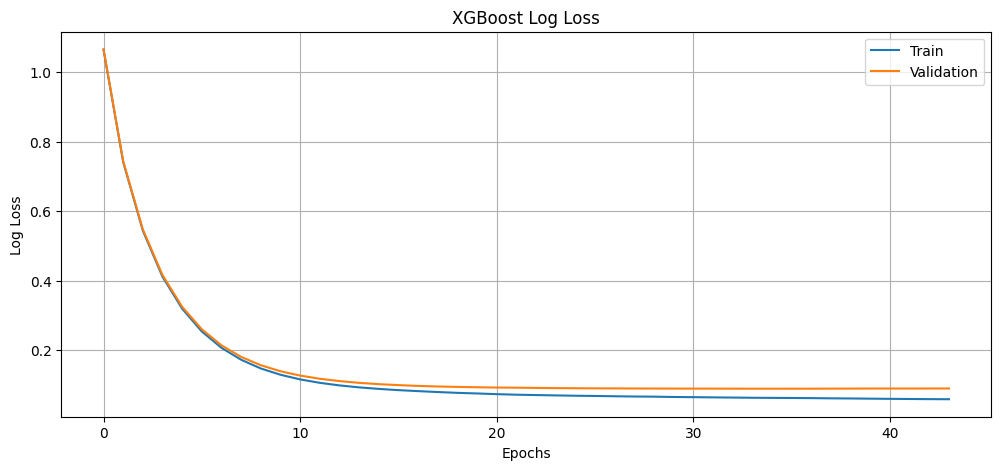

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


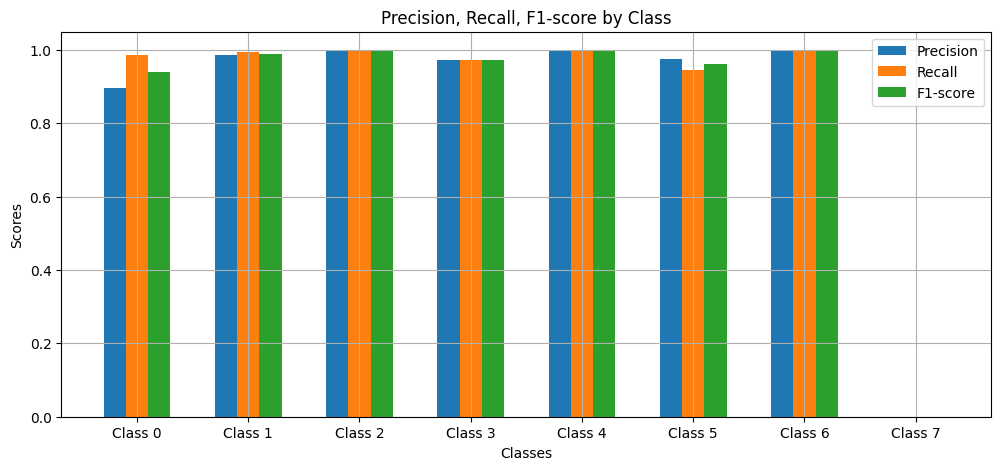

In [27]:
# 순차적으로 LOF 결과 기반 이상치 제거 및 모델 학습
lof_results_list = [Auto_LOF5, Auto_LOF3, Auto_LOF7]
column_names = ['is_level_7_k5', 'is_level_7_k3', 'is_level_7_k7']
for i, (lof_results, column_name) in enumerate(zip(lof_results_list, column_names)):
    filtered_train_ids = embeddings
    filtered_labels = labels
    filtered_train_ids, filtered_labels = remove_anomalies_7(filtered_train_ids, filtered_labels, lof_results, column_name)
    print(f'Filtered train ids shape after removing {column_name}: {filtered_train_ids.shape}')

    # LOF에서 찾은 level 7 데이터 포함
    level_7_indices = lof_results[lof_results[column_name]].index.tolist()
    level_7_embeddings = embeddings[level_7_indices]
    level_7_labels = torch.tensor([7] * len(level_7_indices))

    # 기존 데이터와 합치기
    filtered_train_ids = torch.cat((filtered_train_ids, level_7_embeddings), dim=0)
    filtered_labels = np.concatenate((filtered_labels, level_7_labels.numpy()), axis=0)

    # 모델 학습
    bst, eval_results, y_val, y_pred, report = train_xgboost_7(filtered_train_ids, filtered_labels, weighted_classes=[2, 4, 6 , 7])  # 클래스 2, 4, 6에 가중치를 부여

    # 테스트 데이터 예측
    dtest = xgb.DMatrix(test_embeddings.numpy())
    test_pred = bst.predict(dtest)

    # 예측 결과 추가
    final_predictions = test_pred.copy()

    lof_results[column_name] = lof_results[column_name].astype(bool)
    level_7_indices = lof_results[lof_results[column_name]].index.values
    # level 7 예측 결과 추가
    final_predictions[level_7_indices] = 7

    # 예측 결과를 정수로 변환하여 CSV로 저장
    submission_df['level'] = final_predictions.astype(int)
    submission_df.to_csv(f'final_submission_k{[5, 3, 7][i]}.csv', index=False)
    print(f'Saved predictions for K={[5, 3, 7][i]} as final_submission_k{[5, 3, 7][i]}.csv')

    # 학습 그래프 및 성능 시각화
    plot_metrics(eval_results, report)

## Disti-bert PCA Xgbost

In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix
import xgboost as xgb

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


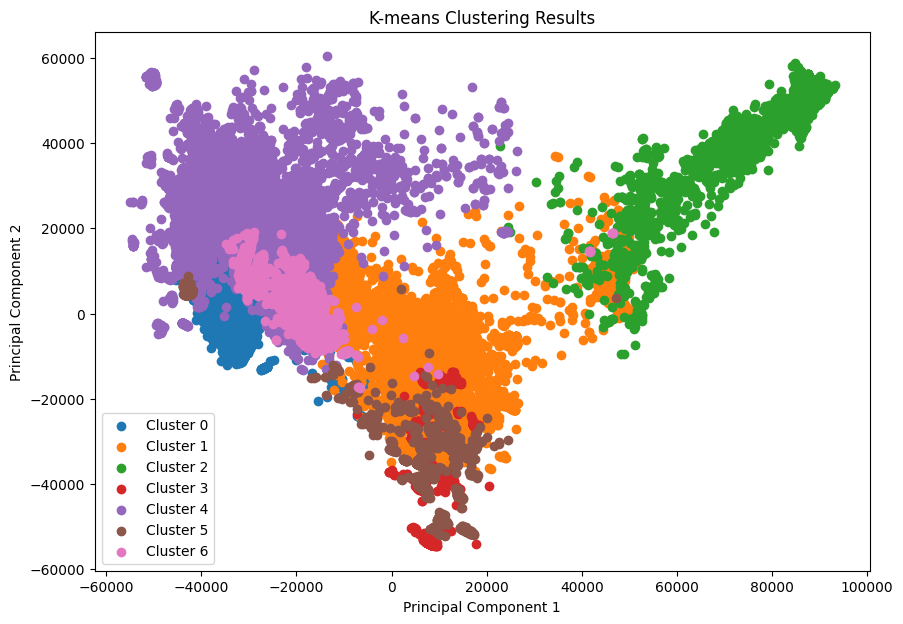

In [ ]:
# PyTorch 텐서 로드
input_ids = torch.load('/content/drive/MyDrive/challenge_log_data/train_ids.pt')

# PyTorch 텐서를 numpy 배열로 변환
X_features = input_ids.numpy()

# K-means 클러스터링 수행
num_clusters = 7  # 원하는 클러스터 수
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_features)

# 클러스터 할당 결과
cluster_labels = kmeans.labels_

# PCA를 사용하여 데이터 차원 축소 (2D 시각화)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_features)

# 클러스터링 결과 시각화
plt.figure(figsize=(10, 7))
for i in range(num_clusters):
    plt.scatter(principal_components[cluster_labels == i, 0], principal_components[cluster_labels == i, 1], label=f'Cluster {i}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results')
plt.legend()
plt.show()


In [ ]:
# 데이터 분할
y_labels = cluster_labels
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)

# XGBoost 모델 정의
model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_clusters, random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4, 6],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [ ]:
# f1_score - macro 스코어링 함수 설정
f1_macro_scorer = make_scorer(f1_score, average='macro')

# GridSearchCV 정의
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=f1_macro_scorer, cv=3, verbose=1, n_jobs=2)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1-macro score ", grid_search.best_score_)

# 최적의 모델로 예측 확률 계산
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
best_model.save_model('/content/drive/MyDrive/challenge_log_data/disti-bert_XGB_best_model.xgb')


Fitting 3 folds for each of 32 candidates, totalling 96 fits


KeyboardInterrupt: 

In [ ]:
# 성능 평가
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 제출 파일 생성
Xg_submission_df = pd.DataFrame({
    'id': np.arange(X_test.shape[0]),
    'level': y_pred
})

# 중복 제거
Xg_submission_df = Xg_submission_df.drop_duplicates()

# Xg_submission_df에서 level 7 데이터를 제거
Xg_submission_df = Xg_submission_df[Xg_submission_df['level'] != 7]
